# Introduction

This code only needs to be run once, in order to authorize the Collabatory project and mount google drive.

In [1]:
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse
from google.colab import auth
auth.authenticate_user()
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}

··········
/bin/sh: 1: google-drive-ocamlfuse: not found


In [6]:
!mkdir -p drive
!google-drive-ocamlfuse drive

/bin/sh: 1: google-drive-ocamlfuse: not found


# Setup

This section performs initial setup of the project. This includes importing libraries, and loading and pre-processing content and style images.

This section may need to be edited depending on what the root folder is. it doesn't like to change to "drive/AIP_Miniproject" so may have to be called twice, ones to "drive" then again to "AIP_Miniproject"

In [5]:
import os
#os.chdir("drive")
!dir

datalab


In [4]:
from __future__ import print_function
import time
from PIL import Image
import numpy as np

from keras import backend
from keras.models import Model
from keras.applications.vgg16 import VGG16

from scipy.optimize import fmin_l_bfgs_b
from scipy.misc import imsave


Using TensorFlow backend.


In [5]:
height = 512
width = 512

content_img_path = 'selfie.jpg'
content_img = Image.open(content_img_path)
content_img = content_img.resize((height, width))
content_img

FileNotFoundError: ignored

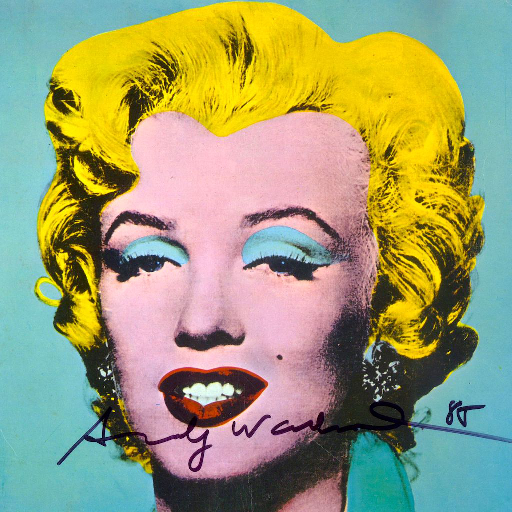

In [38]:
style_img_path = 'marilyn.jpg'
#style_img_path = 'drive/AIP_Miniproject/content/selfie.jpg'
#other style images:
#block.jpg
#forest.jpg
#gothic.jpg
#marilyn.jpg
#picasso.jpg
#scream.jpg
#starry_night.jpg
#van_gough.jpg
#wave.jpg
style_img = Image.open(style_img_path)
style_img = style_img.resize((height, width))
style_img


Create arrays from images. array dimensions default to width, height, color (512, 512, 3).

expand dims adds an extra dimension that is used to concatenate two images into a common structure.

In [6]:
content_array = np.asarray(content_img, dtype='float32')
content_array = np.expand_dims(content_array, axis=0)
print(content_array.shape)

style_array = np.asarray(style_img, dtype='float32')
style_array = np.expand_dims(style_array, axis=0)
print(style_array.shape)



NameError: ignored

subtracy mean RGB values and  reorganised to BGR

In [0]:
content_array[:,:,:,0] -= 103.939
content_array[:,:,:,1] -= 116.779
content_array[:,:,:,2] -= 123.68
content_array = content_array[:,:,:,::-1]

style_array[:,:,:,0] -= 103.939
style_array[:,:,:,1] -= 116.779
style_array[:,:,:,2] -= 123.68
style_array = style_array[:,:,:,::-1]


In [0]:
content_img = backend.variable(content_array)
style_img = backend.variable(style_array)
combination_img = backend.placeholder((1, height, width, 3))

In [0]:
input_tensor = backend.concatenate([content_img,
                                   style_img,
                                   combination_img], axis=0)

# Use VGG16 model to define loss function


In [0]:
model = VGG16(input_tensor=input_tensor, weights='imagenet', include_top = False)

In [44]:
layers = dict([(layer.name, layer.output) for layer in model.layers])
layers

{'block1_conv1': <tf.Tensor 'block1_conv1_1/Relu:0' shape=(3, 512, 512, 64) dtype=float32>,
 'block1_conv2': <tf.Tensor 'block1_conv2_1/Relu:0' shape=(3, 512, 512, 64) dtype=float32>,
 'block1_pool': <tf.Tensor 'block1_pool_1/MaxPool:0' shape=(3, 256, 256, 64) dtype=float32>,
 'block2_conv1': <tf.Tensor 'block2_conv1_1/Relu:0' shape=(3, 256, 256, 128) dtype=float32>,
 'block2_conv2': <tf.Tensor 'block2_conv2_1/Relu:0' shape=(3, 256, 256, 128) dtype=float32>,
 'block2_pool': <tf.Tensor 'block2_pool_1/MaxPool:0' shape=(3, 128, 128, 128) dtype=float32>,
 'block3_conv1': <tf.Tensor 'block3_conv1_1/Relu:0' shape=(3, 128, 128, 256) dtype=float32>,
 'block3_conv2': <tf.Tensor 'block3_conv2_1/Relu:0' shape=(3, 128, 128, 256) dtype=float32>,
 'block3_conv3': <tf.Tensor 'block3_conv3_1/Relu:0' shape=(3, 128, 128, 256) dtype=float32>,
 'block3_pool': <tf.Tensor 'block3_pool_1/MaxPool:0' shape=(3, 64, 64, 256) dtype=float32>,
 'block4_conv1': <tf.Tensor 'block4_conv1_1/Relu:0' shape=(3, 64, 64, 51

# Weights
These weights are arbitrarily chosen based on experiments, and determine the aesthetic of the output image


In [0]:
content_weight = 0.025
style_weight = 5.0
total_variation_weight = 1.0

In [0]:
loss = backend.variable(0.)

#Content Loss

Content loss are drawned from block2_conv2 to ensure the structural detial of the content image is kept. The content loss is the scaled squared Euclidian distance between feature representations of the content and combination images

In [0]:
def content_loss(content, combination):
  return backend.sum(backend.square(combination - content))

layer_features = layers['block2_conv2'] # To do: Try different Layers here!
content_img_features = layer_features[0, :, :, :]
combination_features = layer_features[2, :, :, :]

loss += content_weight * content_loss(content_img_features, combination_features)


#Style Loss

Style loss are firstly defined by a gram matrix that are proportional to the covariances of corresponding sets of features, and thus captures information about which features tend to activate together. This will enable the network to only catch information about the style dependent of the content

In [0]:
def gram_matrix(x):
  features = backend.batch_flatten(backend.permute_dimensions(x, (2, 0, 1)))
  gram = backend.dot(features, backend.transpose(features))
  return gram


The style loss is the Frobenius norm of the difference between the Gram matrices of the style and combination images. The layers used below can also be changed for better results.

In [0]:
def style_loss(style, combination):
  s = gram_matrix(style)
  c = gram_matrix(combination)
  channels = 3
  size = height * width
  return backend.sum(backend.square(s - c)) / (4. * (channels ** 2)*(size ** 2))

feature_layers = ['block1_conv2', 'block2_conv2', 'block3_conv3', 'block4_conv3', 'block5_conv3']

for layer_name in feature_layers:
  layer_features = layers[layer_name]
  style_features = layer_features[1, :, :, :]
  combination_features = layer_features[2, :, :, :]
  sl = style_loss(style_features, combination_features)
  loss += (style_weight / len(feature_layers)) * sl
  
  

#Total Variation Loss

Total variation loss reduces the noisiness of the output image.

In [0]:
def total_variation_loss(x):
  a = backend.square(x[:, :height-1, :width-1, :]-x[:, 1:, :width-1, :])
  b = backend.square(x[:, :height-1, :width-1, :]-x[:, :height-1, 1:, :])
  return backend.sum(backend.pow(a + b, 1.25))

loss += total_variation_weight * total_variation_loss(combination_img)

In [0]:
grads = backend.gradients(loss, combination_img)

In [0]:
outputs = [loss]
outputs += grads
f_outputs = backend.function([combination_img], outputs)

def eval_loss_and_grads(x):
  x = x.reshape((1, height, width, 3))
  outs = f_outputs([x])
  loss_value = outs[0]
  grad_values = outs[1].flatten().astype('float64')
  return loss_value, grad_values

class Evaluator(object):
  
  def __init__(self):
        self.loss_value = None
        self.grads_values = None

  def loss(self, x):
        assert self.loss_value is None
        loss_value, grad_values = eval_loss_and_grads(x)
        self.loss_value = loss_value
        self.grad_values = grad_values
        return self.loss_value

  def grads(self, x):
        assert self.loss_value is not None
        grad_values = np.copy(self.grad_values)
        self.loss_value = None
        self.grad_values = None
        return grad_values
      
evaluator = Evaluator()

In [55]:
x = np.random.uniform(0, 255, (1, height, width, 3)) - 128.

iterations = 1

for i in range(iterations):
  print('Start of iteration', i)
  start_time = time.time()
  x, min_val, info = fmin_l_bfgs_b(evaluator.loss, x.flatten(),
                                     fprime=evaluator.grads, maxfun=20)
  
  
  print('Current loss value:', min_val)
  end_time = time.time()
  print('Iteration %d completed in %ds' % (i, end_time - start_time))
  

Start of iteration 0


ResourceExhaustedError: ignored

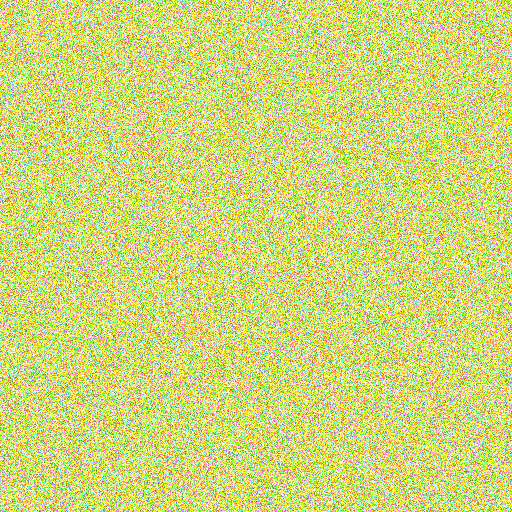

In [35]:
x = x.reshape((height, width, 3))
x = x[:,:,::-1]
x[:,:,0] += 103.939
x[:,:,1] += 116.779
x[:,:,:] += 123.68

x = np.clip(x, 0, 255).astype('uint8')
Image.fromarray(x)
